In [1]:
import pandas as pd
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

WORK_DIR = '../'
results_dir = os.path.join(WORK_DIR, 'results', 'estimates')

In [2]:
emb_stats = pd.read_csv(os.path.join(results_dir, 'embeddings_stats.csv'))
emb_stats.rename(columns={'time':'chunk emb time (seconds)','size (bytes)': 'chunk size (bytes)', 'n_samples': 'samples per chunk'}, inplace=True)
emb_stats

,task,model,chunk emb time (seconds),samples per chunk,chunk size (bytes)
0,gene_finding,hyenadna-tiny-1k,1136.719639,4783,16974564567
1,enhancer_annotation,hyenadna-tiny-1k,83.364254,28,1331168444
2,histone_modification,hyenadna-tiny-1k,878.459177,50000,12167916103
3,chromatin_accessibility,hyenadna-tiny-1k,876.718117,50000,12161888991
4,cpg_methylation,hyenadna-tiny-1k,874.093837,50000,12177768906
5,gene_finding,hyenadna-large-1m,1979.431083,4783,33897712652
6,enhancer_annotation,hyenadna-large-1m,148.898188,28,2656704110
7,histone_modification,hyenadna-large-1m,1992.294050,50000,24278876951
8,chromatin_accessibility,hyenadna-large-1m,2031.097446,50000,24272783417
9,cpg_methylation,hyenadna-large-1m,2050.380581,50000,24276876162


In [3]:
downstream_stats = pd.read_csv(os.path.join(results_dir, 'downstream_stats.csv'))
downstream_stats = downstream_stats[downstream_stats['epoch'] == 1].drop(columns=['epoch'])
downstream_stats.rename(columns={'time':'chunk training time (seconds)'}, inplace=True)
downstream_stats

,task,model,chunk training time (seconds)
0,gene_finding,hyenadna-tiny-1k,162.424445
2,enhancer_annotation,hyenadna-tiny-1k,14.042472
4,histone_modification,hyenadna-tiny-1k,120.563790
6,chromatin_accessibility,hyenadna-tiny-1k,121.548147
8,cpg_methylation,hyenadna-tiny-1k,122.220143
10,gene_finding,hyenadna-large-1m,318.331048
12,enhancer_annotation,hyenadna-large-1m,26.340381
14,histone_modification,hyenadna-large-1m,218.308265
16,chromatin_accessibility,hyenadna-large-1m,219.620006
18,cpg_methylation,hyenadna-large-1m,220.473587


In [4]:
df_stats = pd.merge(
    emb_stats,
    downstream_stats,
    on=['model', 'task'],
    how='outer',
    suffixes=('_emb', '_downstream'),
)
df_stats = df_stats.sort_values(by=['task', 'model'])
df_stats

,task,model,chunk emb time (seconds),samples per chunk,chunk size (bytes),chunk training time (seconds)
0,chromatin_accessibility,awdlstm,45647.244015,50000,6149063713,75.821520
5,chromatin_accessibility,dnabert2,2406.577733,50000,14938810500,305.282444
10,chromatin_accessibility,hyenadna-large-1m,2031.097446,50000,24272783417,219.620006
15,chromatin_accessibility,hyenadna-tiny-1k,876.718117,50000,12161888991,121.548147
20,chromatin_accessibility,nt_transformer_human_ref,3726.499189,50000,21785561139,480.304862
25,chromatin_accessibility,nt_transformer_ms,7478.985198,50000,43566818468,987.211269
30,chromatin_accessibility,nt_transformer_v2_500m,3995.622332,50000,17348286356,405.769217
35,chromatin_accessibility,resnetlm,4382.098835,50000,24269158218,221.764109
1,cpg_methylation,awdlstm,45699.641437,50000,6138572342,75.516522
6,cpg_methylation,dnabert2,2351.995415,50000,14487544142,298.479223


In [5]:
task_len = {}
for task in df_stats['task'].unique():
    df_task = pd.read_csv(os.path.join(WORK_DIR, 'data',task, f'{task}.bed'), sep='\t', low_memory=False)
    task_len[task] = len(df_task)

df_stats['total samples'] = df_stats['task'].map(task_len)
df_stats['n chunks'] = df_stats['total samples'] / df_stats['samples per chunk']

df_stats['chunk size (GB)'] = df_stats['chunk size (bytes)'] / (1024 ** 3)

df_stats['total emb time (hours)'] = (df_stats['chunk emb time (seconds)'] * df_stats['n chunks']) / 3600
df_stats['total emb time (days)'] = df_stats['total emb time (hours)'] / 24
df_stats['total emb size (GB)'] = df_stats['chunk size (bytes)'] * df_stats['n chunks'] / (1024 ** 3)

df_stats['epoch training time (hours)'] = df_stats['chunk training time (seconds)'] * df_stats['n chunks'] / 3600
total_epochs = 100
df_stats['total training time (hours)'] = df_stats['epoch training time (hours)'] * total_epochs
df_stats['total training time (days)'] = df_stats['total training time (hours)'] / 24

df_stats

,task,model,chunk emb time (seconds),samples per chunk,chunk size (bytes),chunk training time (seconds),total samples,n chunks,chunk size (GB),total emb time (hours),total emb time (days),total emb size (GB),epoch training time (hours),total training time (hours),total training time (days)
0,chromatin_accessibility,awdlstm,45647.244015,50000,6149063713,75.821520,2062129,41.242580,5.726762,522.947254,21.789469,236.186434,0.868632,86.863197,3.619300
5,chromatin_accessibility,dnabert2,2406.577733,50000,14938810500,305.282444,2062129,41.242580,13.912851,27.570410,1.148767,573.801889,3.497399,349.739878,14.572495
10,chromatin_accessibility,hyenadna-large-1m,2031.097446,50000,24272783417,219.620006,2062129,41.242580,22.605791,23.268805,0.969534,932.321150,2.516027,251.602657,10.483444
15,chromatin_accessibility,hyenadna-tiny-1k,876.718117,50000,12161888991,121.548147,2062129,41.242580,11.326642,10.043921,0.418497,467.139929,1.392489,139.248866,5.802036
20,chromatin_accessibility,nt_transformer_human_ref,3726.499189,50000,21785561139,480.304862,2062129,41.242580,20.289385,42.691789,1.778825,836.786579,5.502503,550.250325,22.927097
25,chromatin_accessibility,nt_transformer_ms,7478.985198,50000,43566818468,987.211269,2062129,41.242580,40.574762,85.681290,3.570054,1673.407849,11.309761,1130.976104,47.124004
30,chromatin_accessibility,nt_transformer_v2_500m,3995.622332,50000,17348286356,405.769217,2062129,41.242580,16.156851,45.774937,1.907289,666.350208,4.648603,464.860261,19.369178
35,chromatin_accessibility,resnetlm,4382.098835,50000,24269158218,221.764109,2062129,41.242580,22.602415,50.202517,2.091772,932.181905,2.540590,254.059001,10.585792
1,cpg_methylation,awdlstm,45699.641437,50000,6138572342,75.516522,959039,19.180780,5.716991,243.487436,10.145310,109.656347,0.402352,40.235161,1.676465
6,cpg_methylation,dnabert2,2351.995415,50000,14487544142,298.479223,959039,19.180780,13.492577,12.531419,0.522142,258.798149,1.590296,159.029564,6.626232


In [6]:
df_stats.groupby(['model']).sum(numeric_only=True).sort_values(by='total emb size (GB)', ascending=False)['total emb size (GB)']

model
nt_transformer_ms           3073.031202
hyenadna-large-1m           1713.372751
resnetlm                    1713.033909
nt_transformer_human_ref    1536.381586
nt_transformer_v2_500m      1223.715215
dnabert2                    1048.333149
hyenadna-tiny-1k             858.756578
awdlstm                      433.686389
Name: total emb size (GB), dtype: float64

In [ ]:
df_stats = df_stats[df_stats['model'] != 'awdlstm'] # Exclude awdlstm as it is an outlier in terms of size and time

([0, 1, 2, 3, 4],
 [Text(0, 0, 'chromatin_accessibility'),
  Text(1, 0, 'cpg_methylation'),
  Text(2, 0, 'histone_modification'),
  Text(3, 0, 'gene_finding'),
  Text(4, 0, 'enhancer_annotation')])

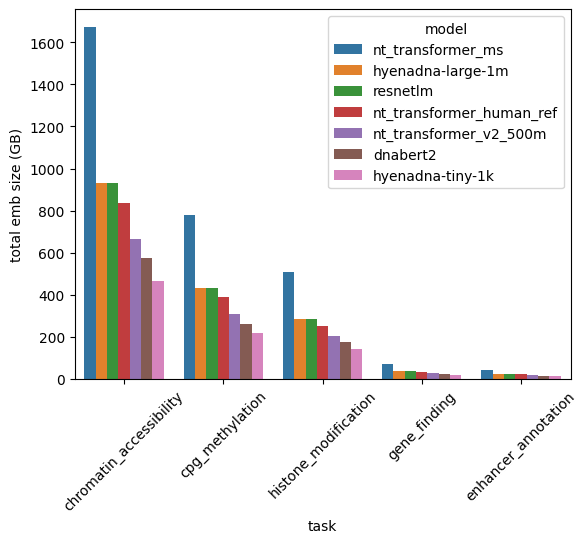

In [11]:
sns.barplot(data=df_stats.sort_values(by='total emb size (GB)', ascending=False), x='task', y='total emb size (GB)', hue='model')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'chromatin_accessibility'),
  Text(1, 0, 'cpg_methylation'),
  Text(2, 0, 'histone_modification'),
  Text(3, 0, 'gene_finding'),
  Text(4, 0, 'enhancer_annotation')])

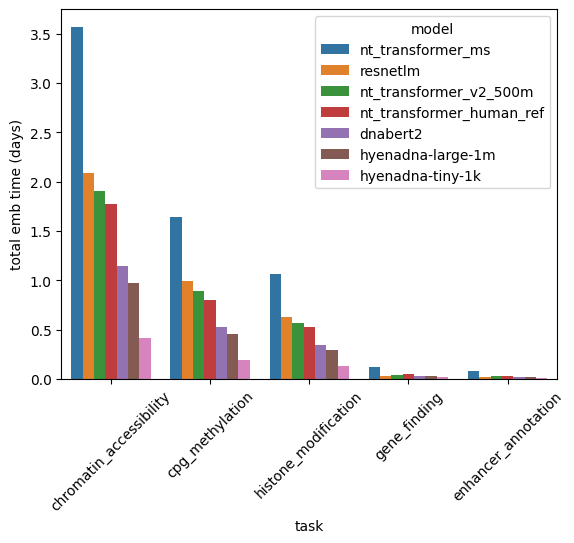

In [12]:
sns.barplot(data=df_stats.sort_values(by='total emb time (days)', ascending=False), x='task', y='total emb time (days)', hue='model')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'chromatin_accessibility'),
  Text(1, 0, 'cpg_methylation'),
  Text(2, 0, 'histone_modification'),
  Text(3, 0, 'gene_finding'),
  Text(4, 0, 'enhancer_annotation')])

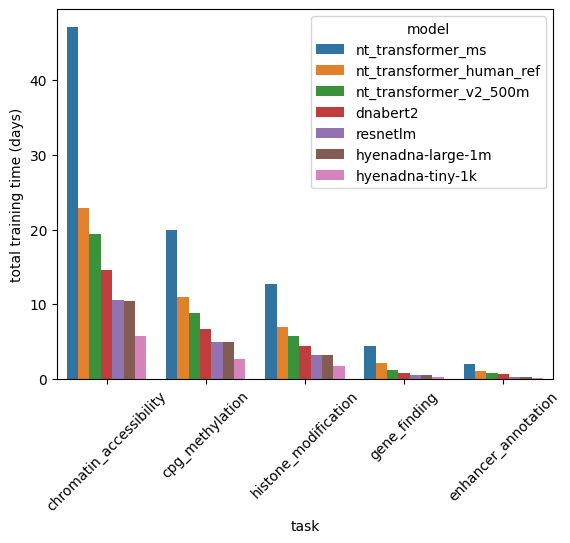

In [13]:
sns.barplot(data=df_stats.sort_values(by='total training time (days)', ascending=False), x='task', y='total training time (days)', hue='model')
plt.xticks(rotation=45)